# Gradient Descent for Finding Stellar Wind Parameters

## Imports

In [1]:
# numerics
import jax
import jax.numpy as jnp
import optax
# put on cpu
jax.config.update("jax_platform_name", "cpu")
# 64-bit precision
jax.config.update("jax_enable_x64", True)

# plotting
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable

# fluids
from jf1uids import OPEN_BOUNDARY, REFLECTIVE_BOUNDARY
from jf1uids import SPHERICAL
from jf1uids.physics_modules.stellar_wind.stellar_wind import WindParams
from jf1uids import strongest_shock_radius
from jf1uids import SimulationConfig
from jf1uids import get_helper_data
from jf1uids import SimulationParams
from jf1uids import time_integration
from jf1uids import primitive_state

# units
from jf1uids import CodeUnits
from astropy import units as u
import astropy.constants as c

## Initiating the stellar wind simulation

In [2]:
print("👷 Setting up simulation...")

# simulation settings
gamma = 5/3

# spatial domain
alpha = SPHERICAL
box_size = 1.0

# ATTENTION: For testing we can take a lower resolution, the 3600 simulation
# for the loss-map from the paper with the settings from the paper take
# roughly 37 minutes and the gradient descents ~1h to run on the CPU
# of an AMD EPYC 7452 32-Core Processor.

fast_instead_paper = True

if fast_instead_paper:
    # Lower resolution is faster
    # especially as then we can also
    # take larger timesteps

    # setting for quick testing
    num_cells = 101
    num_timesteps = 4000
else:
    # setting from the paper
    num_cells = 401
    num_timesteps = 20000

# ATTENTION: Backwards differentiation, the default for jax
# gradient is currently only supported for a fixed timestep.
fixed_timestep = False

adaptive_timesteps_backwards_differentiable = True
num_checkpoints = 200

# boundary condition
left_boundary = REFLECTIVE_BOUNDARY
right_boundary = OPEN_BOUNDARY

# activate stellar wind
stellar_wind = True

# setup simulation config
config = SimulationConfig(
    alpha_geom = alpha,
    box_size = box_size, 
    num_cells = num_cells,
    dx = box_size / (num_cells - 1),
    left_boundary = left_boundary, 
    right_boundary = right_boundary, 
    stellar_wind = stellar_wind,
    fixed_timestep = fixed_timestep,
    adaptive_timesteps_backwards_differentiable = adaptive_timesteps_backwards_differentiable,
    num_checkpoints = num_checkpoints,
    num_timesteps = num_timesteps
)

helper_data = get_helper_data(config)

👷 Setting up simulation...


2024-09-17 16:44:07.043182: W external/xla/xla/service/platform_util.cc:206] unable to create StreamExecutor for CUDA:7: failed initializing StreamExecutor for CUDA device ordinal 7: RESOURCE_EXHAUSTED: : CUDA_ERROR_OUT_OF_MEMORY: out of memory


## Setting the simulation parameters and initial state

In [3]:
# code units
code_length = 3 * u.parsec
code_mass = 1e-4 * u.M_sun
code_velocity = 1 * u.km / u.s
code_units = CodeUnits(code_length, code_mass, code_velocity)

# time domain
C_CFL = 0.8
t_final = 2.5 * 1e4 * u.yr
t_end = t_final.to(code_units.code_time).value
dt_max = 0.0001 * t_end

params = SimulationParams(
    C_cfl = C_CFL,
    dt_max = dt_max,
    gamma = gamma,
    t_end = t_end
)

# homogeneous initial state
rho_0 = 2 * c.m_p / u.cm**3
p_0 = 3e4 * u.K / u.cm**3 * c.k_B

rho_init = jnp.ones(num_cells) * rho_0.to(code_units.code_density).value
u_init = jnp.zeros(num_cells)
p_init = jnp.ones(num_cells) * p_0.to(code_units.code_pressure).value

# get initial state
initial_state = primitive_state(rho_init, u_init, p_init)

## Setting up a reference simulation

In [4]:
sample_simulation = lambda velocity, mass_loss_rate: time_integration(initial_state, config, SimulationParams(
    C_cfl=params.C_cfl,
    dt_max=params.dt_max,
    gamma=params.gamma,
    t_end=params.t_end,
    wind_params=WindParams(
        wind_mass_loss_rate=mass_loss_rate,
        wind_final_velocity=velocity
    )
), helper_data)

# generate a reference simulation
M_star = 40 * u.M_sun
wind_final_velocity = 2000 * u.km / u.s
wind_mass_loss_rate = 2.965e-3 / (1e6 * u.yr) * M_star

reference_params = WindParams(
    wind_mass_loss_rate = wind_mass_loss_rate.to(code_units.code_mass / code_units.code_time).value,
    wind_final_velocity = wind_final_velocity.to(code_units.code_velocity).value
)

reference_simulation = sample_simulation(
    reference_params.wind_final_velocity,
    reference_params.wind_mass_loss_rate
)

reference_shock_radius = strongest_shock_radius(reference_simulation, helper_data, 10, 5)


## Losses

In [5]:
def density_loss(vel_mass_loss):
    velocity = vel_mass_loss[0]
    mass_loss_rate = vel_mass_loss[1]
    final_state = sample_simulation(velocity, mass_loss_rate)
    return jnp.mean(jnp.abs(final_state[0] - reference_simulation[0]))

def full_profile_loss(vel_mass_loss):
    velocity = vel_mass_loss[0]
    mass_loss_rate = vel_mass_loss[1]
    final_state = sample_simulation(velocity, mass_loss_rate)
    return jnp.sum(jnp.abs(final_state - reference_simulation))

## Loss map

In [6]:
def get_loss_map(velocity_range, mass_loss_rate_range):
    loss_map = jnp.zeros((len(velocity_range) * len(mass_loss_rate_range),))
    vel_list = jnp.zeros((len(velocity_range) * len(mass_loss_rate_range),))
    mass_list = jnp.zeros((len(velocity_range) * len(mass_loss_rate_range),))
    ind = 0

    for i, velocity in enumerate(velocity_range):
        for j, mass_loss_rate in enumerate(mass_loss_rate_range):
            loss_map = loss_map.at[ind].set(density_loss((velocity, mass_loss_rate)))
            vel_list = vel_list.at[ind].set(velocity)
            mass_list = mass_list.at[ind].set(mass_loss_rate)
            ind += 1
    return loss_map, vel_list, mass_list

# generate a loss map
mass_loss_rates = jnp.linspace(
    (2.965e-3 / (1e6 * u.yr) * 15 * u.M_sun).to(code_units.code_mass / code_units.code_time).value,
    (2.965e-3 / (1e6 * u.yr) * 70 * u.M_sun).to(code_units.code_mass / code_units.code_time).value,
    10
)

velocities = jnp.linspace(
    (200 * u.km / u.s).to(code_units.code_velocity).value,
    (4000 * u.km / u.s).to(code_units.code_velocity).value,
    10
)

loss_map, vel_list, mass_list = get_loss_map(velocities, mass_loss_rates)

## Optimization

In [7]:
# also implement gradient descent
def gradient_descent_optimization(func, x_init, learning_rate=20, tol=0.5, max_iter=2000):
    xlist = []
    x = x_init
    loss_list = []
    xlist.append(x)

    optimizer = optax.adam(learning_rate=learning_rate)
    optimizer_state = optimizer.init(x)

    for _ in range(max_iter):
        # Compute the function value and its gradient
        loss, f_grad = jax.value_and_grad(func)(x)
        loss_list.append(loss)
        
        # Update the parameter
        updates, optimizer_state = optimizer.update(f_grad, optimizer_state)
        x = optax.apply_updates(x, updates)
        xlist.append(x)
        
        # Check convergence
        if jnp.linalg.norm(updates) < tol:
            break
    
    return x, xlist, loss_list

## Example loss paths

In [8]:
initial_guess1 = jnp.array([(1500 * u.km / u.s).to(code_units.code_velocity).value, (2.965e-3 / (1e6 * u.yr) * 30 * u.M_sun).to(code_units.code_mass / code_units.code_time).value])
x1, xlist1, loss_list1 = gradient_descent_optimization(full_profile_loss, initial_guess1)

In [9]:
initial_guess2 = jnp.array([(3500 * u.km / u.s).to(code_units.code_velocity).value, (2.965e-3 / (1e6 * u.yr) * 60 * u.M_sun).to(code_units.code_mass / code_units.code_time).value])
x2, xlist2, loss_list2 = gradient_descent_optimization(full_profile_loss, initial_guess2)

In [10]:
initial_guess3 = jnp.array([(3300 * u.km / u.s).to(code_units.code_velocity).value, (2.965e-3 / (1e6 * u.yr) * 45 * u.M_sun).to(code_units.code_mass / code_units.code_time).value])
x3, xlist3, loss_list3 = gradient_descent_optimization(full_profile_loss, initial_guess3)

## Loss map plot

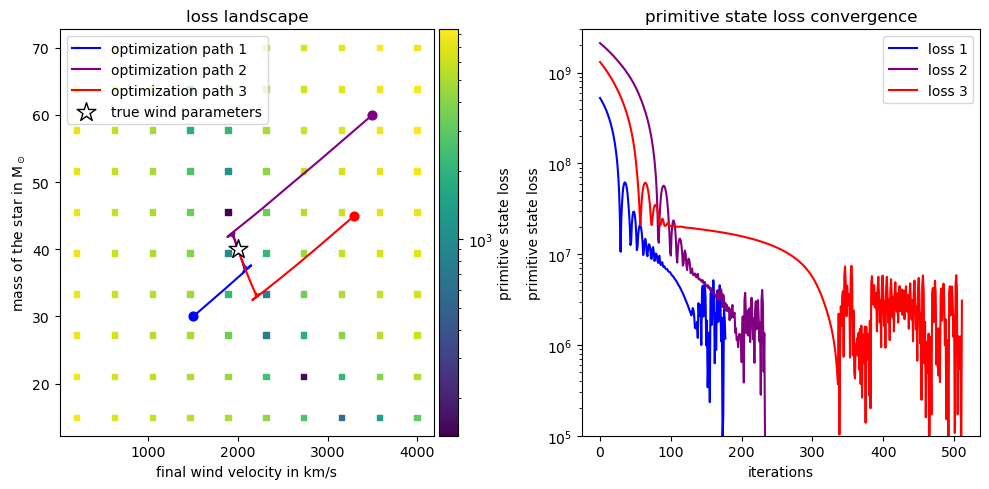

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

divider = make_axes_locatable(axs[0])
cax = divider.append_axes('right', size='5%', pad=0.05)
norm = LogNorm(vmin=loss_map.min(), vmax=loss_map.max())
mapper = plt.cm.ScalarMappable(norm=norm, cmap=plt.cm.viridis)
plt.colorbar(mapper, cax=cax, orientation='vertical', label='primitive state loss')

axs[0].scatter((vel_list * code_units.code_velocity).to(u.km / u.s).value, (mass_list * code_units.code_mass / code_units.code_time).to(2.965e-3 / (1e6 * u.yr) * u.M_sun).value, c=loss_map, cmap='viridis', norm=norm, s = 15, marker = "s")

axs[0].set_xlabel('final wind velocity in km/s')
axs[0].set_ylabel(r'mass of the star in M$_\odot$')
axs[0].set_title('loss landscape')

# plot the loss function
axs[1].plot(loss_list1, label='loss 1', color='blue')

# plot the optimization path
xlist1 = jnp.array(xlist1)
axs[0].plot((xlist1[:, 0] * code_units.code_velocity).to(u.km / u.s).value, (xlist1[:, 1] * code_units.code_mass / code_units.code_time).to(2.965e-3 / (1e6 * u.yr) * u.M_sun).value, color='blue', label='optimization path 1')
axs[0].scatter(
    [(xlist1[0, 0] * code_units.code_velocity).to(u.km / u.s).value], [(xlist1[0, 1] * code_units.code_mass / code_units.code_time).to(2.965e-3 / (1e6 * u.yr) * u.M_sun).value],
    c='blue', s = 40
)

# plot the optimization path
xlist2 = jnp.array(xlist2)
axs[0].plot((xlist2[:, 0] * code_units.code_velocity).to(u.km / u.s).value, (xlist2[:, 1] * code_units.code_mass / code_units.code_time).to(2.965e-3 / (1e6 * u.yr) * u.M_sun).value, color='purple', label='optimization path 2')

axs[0].scatter(
    [(xlist2[0, 0] * code_units.code_velocity).to(u.km / u.s).value], [(xlist2[0, 1] * code_units.code_mass / code_units.code_time).to(2.965e-3 / (1e6 * u.yr) * u.M_sun).value],
    c='purple', s = 40
)

# plot the loss function
axs[1].plot(loss_list2, label='loss 2', color='purple')

# plot the optimization path
xlist3 = jnp.array(xlist3)
axs[0].plot((xlist3[:, 0] * code_units.code_velocity).to(u.km / u.s).value, (xlist3[:, 1] * code_units.code_mass / code_units.code_time).to(2.965e-3 / (1e6 * u.yr) * u.M_sun).value, color='red', label='optimization path 3')

axs[0].scatter(
    [(xlist3[0, 0] * code_units.code_velocity).to(u.km / u.s).value], [(xlist3[0, 1] * code_units.code_mass / code_units.code_time).to(2.965e-3 / (1e6 * u.yr) * u.M_sun).value],
    c='red', s = 40
)

# plot the loss function
axs[1].plot(loss_list3, label='loss 3', color='red')

axs[1].set_xlabel('iterations')
axs[1].set_ylabel('primitive state loss')
axs[1].set_title('primitive state loss convergence')
axs[1].set_yscale('log')
axs[1].legend(loc='upper right')
plt.tight_layout()

# mark the true value as a red dot
axs[0].scatter(
    [wind_final_velocity.to(u.km / u.s).value],
    [wind_mass_loss_rate.to(2.965e-3 / (1e6 * u.yr) * u.M_sun).value],
    c='white', s = 200, label='true wind parameters', marker = "*", zorder = 10, edgecolors='black'
)

axs[0].legend()
axs[1].legend()

# axs 1 y lim 10^6 to 3 * 10^9
if fast_instead_paper:
    axs[1].set_ylim(1e5, 3e9)
else:
    axs[1].set_ylim(1e6, 3e9)

plt.savefig('figures/wind_parameter_optimization.png')